Améliorations ou essais à réaliser :

1.   Optimisation permanente DataClean
2.   Tests Kmeans sur mail initial, NER, best_summary





# 1 - Collecte et Analyse exploratoire

# 1.1 - Collecte des données

Identification de l'environnement de travail (Google Colab ou local)

**!!! : Si environnement Colab, choisir entre :**


*   Bloc 1 : Génération d'un fichier csv "aléatoire" à partir du csv initial (479Mo)
*   Bloc 2 : On repart d'un csv déjà généré




In [ ]:
 from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
COLAB = 'google.colab' in str(get_ipython())

if COLAB:
  print ("Execution in Google Colab")
  # Environnement Nicolas
  import google.colab

  from google.colab import data_table
  data_table.enable_dataframe_formatter()

# Informations sur l'environnement COLAB utilisé
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

  from psutil import virtual_memory
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')

  # Mount GDrive
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  import pandas as pd
  import random
  file_path = "/content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/"
  file_path
  # CHOISIR entre Bloc 1 et Bloc 2 selon que l'on veut regénérer (Bloc 1) ou pas (Bloc 2) un fichier csv initial
  # Enlever ou Mettre en commentaires selon le choix
  #
  # Bloc 1 -------------------------------------------------------------------------------------------------  
  #
  s =1000  # Nbre de lignes selectionnées aléatoirement

#  file_name = "enron_unique"
#  file_name_out = file_name+'_'+str(s)
#  file = file_path+file_name+'.csv'

#  n = sum(1 for line in open(file)) - 1 #number of records in file (excludes header)
#  print(n,' records')
#  skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
#  df = pd.read_csv(file, skiprows=skip)
#  print(df.shape)

  # Bloc 2 -------------------------------------------------------------------------------------------------
  #
  file_name = "enron_unique_10000"
  file_name_out = file_name+'_clean'
  #file_name_out = file_name
  file = file_path+file_name+'.csv'
  df = pd.read_csv(file)
  df.shape

else:
  # Environnement Franck
  COLAB = False
  print ("Execution en local.")
  import pandas as pd
  # Pour limiter les temps de calcul on travaille uniquement sur les 'nrows' premiers mails
  file = "/Users/franckglastre/emaildata_100000_0.csv"
  file_name_out = file
  df = pd.read_csv(file, nrows=200)
  #df = pd.read_csv("emaildata_100000_0.csv", nrows=200)

Execution in Google Colab
Not connected to a GPU
Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
Mounted at /content/drive


In [ ]:

print("Fichier de sortie : ",file_name_out,".csv ",df.shape)

Fichier de sortie :  enron_unique_10000_clean .csv  (10000, 11)


In [ ]:
df.head()

,date,from,to,header,body,cc,body_clean,body_principal,body_dict,NER_header,NER_body
0,2000-08-10 15:02:00-07:00,phillip.allen@enron.com,stephanie.sever@enron.com,Re: Your approval is requested,"['', 'Stephanie', '', 'Please grant Paul the r...",NaN,NaN,NaN,NaN,NaN,NaN
1,2000-08-08 09:31:00-07:00,phillip.allen@enron.com,ina.rangel@enron.com,Your Approval is Overdue: Access Request for p...,"['', 'Ina,', '', ' How many times do you think...",NaN,NaN,NaN,NaN,NaN,NaN
2,2000-06-08 10:17:00-07:00,phillip.allen@enron.com,jeff.richter@enron.com,NaN,"['', 'Check out NP Gen & Load. (aMW)']",NaN,NaN,NaN,NaN,NaN,NaN
3,2000-05-11 01:16:00-07:00,phillip.allen@enron.com,dawn.kenne@enron.com,Re: 5/08/00,"['', 'Dawn,', '', ""I received your email with ...",NaN,NaN,NaN,NaN,NaN,NaN
4,2000-03-30 01:58:00-08:00,phillip.allen@enron.com,jsmith@austintx.com,RE: Inspection for Mission South,"['', 'Are we going to inspect tomorrow?']",NaN,NaN,NaN,NaN,NaN,NaN


Modification structures

In [ ]:
# Renommage des colonnes
df = df.rename(columns={'sender': 'from', 'recipient1': 'to','subject': 'header', 'text': 'body'})

# Création colonnes pour traitements ultérieurs
df['cc'] = ''                        # pour identfication des personnes en copie
df['body_clean'] = ''                # body sans caracteres parasites V1
df['body_principal'] = ''            # mail INITIAL seulement
df['body_dict'] = ''                 # body tokenisé
# df['summary_TFIDF'] = ''             # extractive summary by TF-IDF
# df['summary_TFIDF_sim'] = ''         # calcul de similarité par rapport à body_clean
# df['summary_spacy'] = ''             # extractive summary by Spacy
# df['summary_spacy_sim'] = ''         # calcul de similarité par rapport à body_clean
# df['summary_BART'] = ''              # abstractive summary by HugginFace/BART
# df['summary_BART_sim'] = ''          # calcul de similarité par rapport à body_clean
# df['summary_T5'] = ''                # abstractive summary by HugginFace/T5
# df['summary_T5_sim'] = ''            # calcul de similarité par rapport à body_clean
# df['best_sim'] = ''                  # meilleure taux de similarité par rapport à body_clean
df['NER_header'] = ''                # Spacy NER
df['NER_body'] = ''                  # Spacy NER

deb = 0
fin = df.shape[0]
df.head()

,date,from,to,header,body,cc,body_clean,body_principal,body_dict,NER_header,NER_body
0,2000-08-10 15:02:00-07:00,phillip.allen@enron.com,stephanie.sever@enron.com,Re: Your approval is requested,"['', 'Stephanie', '', 'Please grant Paul the r...",,,,,,
1,2000-08-08 09:31:00-07:00,phillip.allen@enron.com,ina.rangel@enron.com,Your Approval is Overdue: Access Request for p...,"['', 'Ina,', '', ' How many times do you think...",,,,,,
2,2000-06-08 10:17:00-07:00,phillip.allen@enron.com,jeff.richter@enron.com,NaN,"['', 'Check out NP Gen & Load. (aMW)']",,,,,,
3,2000-05-11 01:16:00-07:00,phillip.allen@enron.com,dawn.kenne@enron.com,Re: 5/08/00,"['', 'Dawn,', '', ""I received your email with ...",,,,,,
4,2000-03-30 01:58:00-08:00,phillip.allen@enron.com,jsmith@austintx.com,RE: Inspection for Mission South,"['', 'Are we going to inspect tomorrow?']",,,,,,


# 1.1.1 - Fonction - Sauvegarde vers CSV

In [ ]:
# SAUVEGARDE en csv du résultat.
import datetime
from dateutil import tz

def svgd_csv_xls (file_path,file_name):
  import datetime
  from dateutil import tz
  date = datetime.datetime.now()
  FRA = tz.gettz('Europe/Paris')
  d2 = date.astimezone(tz=FRA)
  date = d2.strftime("%b %d %Y %H:%M")

# to .CSV
  file_extension = ".csv"
  file = file_path+file_name+" "+str(date)+file_extension
  df.to_csv(file, encoding='utf-8', index=False)
  print("Svgde effectuée - ",date," - ",file)
  return

In [ ]:

file_name_out = file_name+'_TFIDF_tmp_'
file_name_tmp = file_name_out+"_"+str(id)
    
file = file_path+file_name_tmp
svgd_csv_xls (file_path,file_name_tmp)

Svgde effectuée -  Sep 18 2022 01:07  -  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_10000_clean 2022-09-15 11:27:39.338137_TFIDF_tmp__4000 Sep 17 2022 18:42_TFIDF_tmp__<built-in function id> Sep 18 2022 01:07.csv


In [ ]:
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
  # Environnement Nicolas
  svgd_csv_xls (file_path,file_name_out)
else:
  # Environnement Franck
  df.to_csv("/Users/franckglastre/Documents/GitHub/NLP-Datascientest/data_clean.csv",encoding="utf-8", index=False)

File :  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_10000_clean 2022-09-15 11:06:56.426437.csv
Svgde effectuée -  2022-09-15 11:06:56.426437


# 1.2 - Analyse exploratoire des datas (1)



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            10000 non-null  object
 1   from            10000 non-null  object
 2   to              10000 non-null  object
 3   header          9655 non-null   object
 4   body            10000 non-null  object
 5   cc              10000 non-null  object
 6   body_clean      10000 non-null  object
 7   body_principal  10000 non-null  object
 8   body_dict       10000 non-null  object
 9   NER_header      10000 non-null  object
 10  NER_body        10000 non-null  object
dtypes: object(11)
memory usage: 859.5+ KB


In [ ]:
#pas de données quantitatives, pas de renseignement ici....
df.describe()

,date,from,to,header,body,cc,body_clean,body_principal,body_dict,NER_header,NER_body
count,10000,10000,10000,9655,10000,10000,10000,10000,10000,10000,10000
unique,9835,2935,3220,8536,9992,1,1,1,1,1,1
top,1979-12-31 16:00:00-08:00,pete.davis@enron.com,pete.davis@enron.com,RE:,"['', 'test']",,,,,,
freq,8,404,403,222,3,10000,10000,10000,10000,10000,10000


In [ ]:
# identification des valeurs manquantes
# ici, nombreux headers (Suject) manquants
info_manq = df.isnull().sum()
print(info_manq)

date                0
from                0
to                  0
header            345
body                0
cc                  0
body_clean          0
body_principal      0
body_dict           0
NER_header          0
NER_body            0
dtype: int64


In [ ]:
# période couverte de la base d'email
df['Datetime']=df['date'].apply(lambda x:x[:10])
df['Datetime'] = pd.to_datetime(df['Datetime'],format="%Y/%m/%d")
print("années: ",df['Datetime'].dt.year.unique())
print("mois: ",df['Datetime'].dt.month.unique())
print("jours: ",df['Datetime'].dt.day.unique())

années:  [2000 2001 1979 2002 1999 1997 2004 1998]
mois:  [ 8  6  5  3  1  4  2 12 11 10  7  9]
jours:  [10  8 11 30 20  3 31 26 29 14 12  7 23  9  6 18  5 22 13 24 17 16 21 19
 27 25  4  2 15  1 28]


In [ ]:
# répartition des emails
print(df.groupby([df['Datetime'].dt.year])['date'].aggregate('count'))
print(df.groupby([df['Datetime'].dt.year,df['Datetime'].dt.month])['date'].aggregate('count'))

Datetime
1979       8
1997       1
1998       2
1999     210
2000    2642
2001    6016
2002    1117
2004       4
Name: date, dtype: int64
Datetime  Datetime
1979      12             8
1997      1              1
1998      12             2
1999      1              1
          2              1
          3              1
          4              1
          5             17
          6             12
          7             28
          8             14
          9             28
          10            39
          11            27
          12            41
2000      1             95
          2            111
          3            136
          4            134
          5            170
          6            188
          7            173
          8            239
          9            257
          10           328
          11           404
          12           407
2001      1            313
          2            318
          3            455
          4            758
      

# 1.3 - Data Cleaning

Fonction : regex

In [ ]:
# préparation du corpus de mots avec fonction de nettoyage
# prend une string / retourne une string

import re
def data_cleanstr(string):
    r = re.compile(r'[a-zA-Z0-9.-]*@[a-zA-Z0-9.-]*')
    tok=r.sub('mail', string)
    
    r = re.compile(r"([^a-zA-Z\.$]+)")
    tok1=r.sub(' ', tok)
    return tok1


Execution Regex

In [ ]:
df['body_principal'] = df['body_principal'].apply(lambda d:data_cleanstr(d))
#df['body_clean'] = df['body_principal'].apply(lambda d:data_cleanstr(d))

# 1.4 - Preprocessing

Fonction : selection de l'email INITIAL

In [ ]:
# fonction pour sélectionner uniquement l'email principal, et éliminer les forwards suivants

def sel_email_principal(df):
    import re
    result = re.finditer(r'\'-+ Forwarded by.{,700}Subject:', df)
    # print all match object
    deb=0
    fin=0
    texte=""
    liste=[]
    for match_obj in result:
        liste.append(match_obj.span())
    if len(liste)==0:
        return df
    if len(liste)==1:
        deb=int(liste[0][0])
        fin=int(liste[0][1])
        return df[fin:]
    if len(liste)>1:
        fin=int(liste[0][1])
        deb=int(liste[1][0])
        return df[fin:deb]

Execution : selection email initial

In [ ]:
# création d'un colonne email uniquement avec l'email principal

df['body_principal'] = df['body'].apply(lambda d:sel_email_principal(d))
df.head()
df[['date','header','body','body_principal']].head()

,date,header,body,body_principal
0,2000-08-10 15:02:00-07:00,Re: Your approval is requested,"['', 'Stephanie', '', 'Please grant Paul the r...","['', 'Stephanie', '', 'Please grant Paul the r..."
1,2000-08-08 09:31:00-07:00,Your Approval is Overdue: Access Request for p...,"['', 'Ina,', '', ' How many times do you think...",Your Approval is Overdue: Access Request for ...
2,2000-06-08 10:17:00-07:00,NaN,"['', 'Check out NP Gen & Load. (aMW)']","['', 'Check out NP Gen & Load. (aMW)']"
3,2000-05-11 01:16:00-07:00,Re: 5/08/00,"['', 'Dawn,', '', ""I received your email with ...","['', 'Dawn,', '', ""I received your email with ..."
4,2000-03-30 01:58:00-08:00,RE: Inspection for Mission South,"['', 'Are we going to inspect tomorrow?']","['', 'Are we going to inspect tomorrow?']"


In [ ]:
df['body_principal'] = df['body_principal'].apply(lambda d:data_cleanstr(d))
df['body_clean'] = df['body'].apply(lambda d:data_cleanstr(d))
df[['body','body_principal','body_clean']].head()

,body,body_principal,body_clean
0,"['', 'Stephanie', '', 'Please grant Paul the r...",Stephanie Please grant Paul the requested eol...,Stephanie Please grant Paul the requested eol...
1,"['', 'Ina,', '', ' How many times do you think...",Your Approval is Overdue Access Request for m...,Ina How many times do you think Jeff wants to...
2,"['', 'Check out NP Gen & Load. (aMW)']",Check out NP Gen Load. aMW,Check out NP Gen Load. aMW
3,"['', 'Dawn,', '', ""I received your email with ...",Dawn I received your email with p l s. Please...,Dawn I received your email with p l s. Please...
4,"['', 'Are we going to inspect tomorrow?']",Are we going to inspect tomorrow,Are we going to inspect tomorrow


In [ ]:
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
  # Environnement Nicolas
  svgd_csv_xls (file_path,file_name_out)
else:
  # Environnement Franck
  df.to_csv("/Users/franckglastre/Documents/GitHub/NLP-Datascientest/data_clean.csv",encoding="utf-8", index=False)

File :  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_10000_clean 2022-09-15 11:07:00.900129.csv
Svgde effectuée -  2022-09-15 11:07:00.900129


Fonction : Tokenisation et lower()

In [ ]:
# tokenisation du corpus de mots, utilisation de la fonction de nettoyage et mise en minuscules
# prend retourne un dataframe / retourne une liste

import nltk
nltk.download('punkt')

def tokenize_mots(df):    
    texte=[]
    phrases=""
    from nltk.tokenize import word_tokenize

    for i in df['body_principal']:
        phrases+=i
    a=data_cleanstr(str(phrases))
    mots=word_tokenize(a)
    mots=[i.lower() for i in mots]
    return mots



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df.shape

(10000, 12)

Execution : Tokenisation et lower() 

In [ ]:
# création liste mots pour corpus
mots=tokenize_mots(df)
print(len(mots))

2620351


In [ ]:
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
  # Environnement Nicolas
  svgd_csv_xls (file_path,file_name_out)
else:
  # Environnement Franck
  df.to_csv("/Users/franckglastre/Documents/GitHub/NLP-Datascientest/data_clean.csv",encoding="utf-8", index=False)

File :  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_10000_clean 2022-09-15 11:16:58.718371.csv
Svgde effectuée -  2022-09-15 11:16:58.718371


Fonction : StopWords

In [ ]:
# préparation fonction stopwords
# prend une string / retourne une string


def remove_stop_words(text):
    import spacy
    from spacy.lang.en.stop_words import STOP_WORDS
    stopwords=list(STOP_WORDS)
    lst=[]

    for token in text.split():
        if token.lower() not in stopwords:    #checking whether the word is not 
            lst.append(token)                    #present in the stopword list.      
            result = ' '.join(lst)
    return result

Execution StopWords

*   choisir entre ce code et la fonction 



In [ ]:
# création liste mots pour corpus sans Stopwords
from spacy.lang.en.stop_words import STOP_WORDS
stopwords=list(STOP_WORDS)
mots_sans=[]
for mot in mots:
  if mot not in stopwords:
    mots_sans.append(mot)

print(len(mots))
print(len(mots_sans))

2620351
1696123


Fonction : Lemmatization

In [ ]:
# lematisation du corpus, 2 ere ligne à réactiver si besoin
# prend une liste / retourne une liste

import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

def lematize_mots(corpus):
    from nltk.stem import WordNetLemmatizer

    # Initialiser un lemmatiseur
    wordnet_lemmatizer = WordNetLemmatizer()

    #Calculer le lemme du mot meeting
    corp=[]
    for mot in corpus:
        a=""
        a=wordnet_lemmatizer.lemmatize(mot)
        corp.append(a)
    #utilisation de list(set()) pour supprimer les doublons
    return list(set(corp))




[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


Execution : Lemmatization

In [ ]:
# création liste pour corpus
corpus=lematize_mots(mots)
corpus_sans=lematize_mots(mots_sans)

print(len(corpus))
print(len(corpus_sans))

60564
60340


Fonction : suppression des Noms de personnes (NER Spacy)

In [ ]:
# fonction pour enlever les noms
#Entrée liste / Sortie liste

def remove_nom(corpus):
    import spacy
    # mise en minuscule du texte
    text=[t.lower() for t in corpus]
    # création d'un string pour préparation spacy
    text=" ".join(text)
    nlp = spacy.load("en_core_web_sm")
    nlp.max_length = 3000000
    doc = nlp(text)
    # création d'une liste de nom sur la base des NER Person de Spacy
    personne = [e.text for e in doc.ents if e.label_=='PERSON']
    lst=[]
    # parcours du texte issu de doc pour neutraliser les Persons
    texte=[token.text for token in doc]
    for token in texte:
        if token not in personne:    #checking whether the word is not 
            lst.append(token)                    #present in the stopword list.      
    return lst



     


Execution : suppression des Noms de personnes (NER Spacy)

In [ ]:
corpus_sans=remove_nom(corpus_sans)
print(len(corpus_sans))

60484


In [ ]:
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
  # Environnement Nicolas
  svgd_csv_xls (file_path,file_name_out)
else:
  # Environnement Franck
  df.to_csv("/Users/franckglastre/Documents/GitHub/NLP-Datascientest/data_clean.csv",encoding="utf-8", index=False)

File :  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_10000_clean 2022-09-15 11:17:55.190908.csv
Svgde effectuée -  2022-09-15 11:17:55.190908


# 1.5 - Vizualisation (WordCloud)

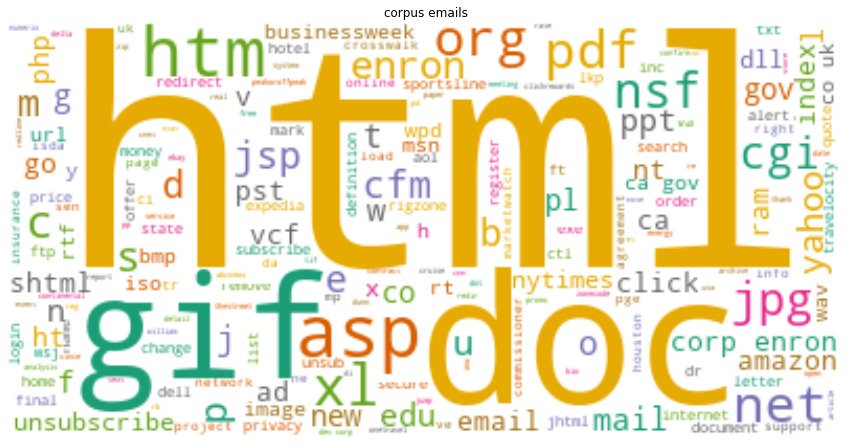

In [ ]:
#visualisation nuage
from wordcloud import WordCloud, STOPWORDS

stop_words = STOPWORDS
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

import matplotlib.pyplot as plt
wc.generate(" ".join(corpus_sans))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

plt.title("corpus emails")
    
plt.show()

# 1.6 - Analyse exploratoire des datas (2)

In [ ]:
df.head(5)

,date,from,to,header,body,cc,body_clean,body_principal,body_dict,NER_header,NER_body,Datetime
0,2000-08-10 15:02:00-07:00,phillip.allen@enron.com,stephanie.sever@enron.com,Re: Your approval is requested,"['', 'Stephanie', '', 'Please grant Paul the r...",,Stephanie Please grant Paul the requested eol...,Stephanie Please grant Paul the requested eol...,,,,2000-08-10
1,2000-08-08 09:31:00-07:00,phillip.allen@enron.com,ina.rangel@enron.com,Your Approval is Overdue: Access Request for p...,"['', 'Ina,', '', ' How many times do you think...",,Ina How many times do you think Jeff wants to...,Your Approval is Overdue Access Request for m...,,,,2000-08-08
2,2000-06-08 10:17:00-07:00,phillip.allen@enron.com,jeff.richter@enron.com,NaN,"['', 'Check out NP Gen & Load. (aMW)']",,Check out NP Gen Load. aMW,Check out NP Gen Load. aMW,,,,2000-06-08
3,2000-05-11 01:16:00-07:00,phillip.allen@enron.com,dawn.kenne@enron.com,Re: 5/08/00,"['', 'Dawn,', '', ""I received your email with ...",,Dawn I received your email with p l s. Please...,Dawn I received your email with p l s. Please...,,,,2000-05-11
4,2000-03-30 01:58:00-08:00,phillip.allen@enron.com,jsmith@austintx.com,RE: Inspection for Mission South,"['', 'Are we going to inspect tomorrow?']",,Are we going to inspect tomorrow,Are we going to inspect tomorrow,,,,2000-03-30


,longueur_body
count,10000.000000
mean,1425.851000
std,3112.464553
min,1.000000
25%,270.000000
50%,666.000000
75%,1469.000000
max,130511.000000


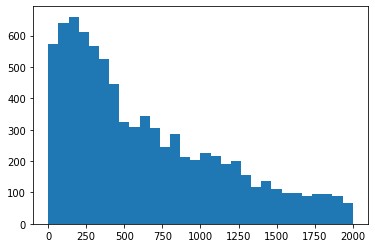

In [ ]:
import matplotlib.pyplot as plt
# distribution longueur d'emails
df['longueur_body']=df['body_principal'].apply(lambda x:len(x))
# distribution de la longueur des emails
plt.hist(df[df['longueur_body']<2000]['longueur_body'],bins=30);
# statistique sur la longueur des emails
df.describe()  

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            10000 non-null  object        
 1   from            10000 non-null  object        
 2   to              10000 non-null  object        
 3   header          9655 non-null   object        
 4   body            10000 non-null  object        
 5   cc              10000 non-null  object        
 6   body_clean      10000 non-null  object        
 7   body_principal  10000 non-null  object        
 8   body_dict       10000 non-null  object        
 9   NER_header      10000 non-null  object        
 10  NER_body        10000 non-null  object        
 11  Datetime        10000 non-null  datetime64[ns]
 12  longueur_body   10000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(11)
memory usage: 1015.8+ KB


In [ ]:
df[df['longueur_body']>2000]['body_principal'].count()
df[df['longueur_body']>2000]['body_principal'].head(1)

25     If you cannot read this email please click he...
Name: body_principal, dtype: object

In [ ]:
# distribution des emails par auteur
print(df["from"].value_counts())
print("  ")
print("nombre de correspondants :",len(df["from"].unique()))

pete.davis@enron.com                                    404
jeff.dasovich@enron.com                                 231
sara.shackleton@enron.com                               222
kay.mann@enron.com                                      210
vince.kaminski@enron.com                                183
                                                       ... 
ebiz@enron.com                                            1
special@flowgo.com                                        1
gary.kenagy@enron.com                                     1
expediafaretracker_031541@expedia.customer-email.com      1
daemon.extra@enron.com                                    1
Name: from, Length: 2935, dtype: int64
  
nombre de correspondants : 2935


In [ ]:
# distribution des emails par destinataire
df["to"].value_counts()

pete.davis@enron.com         403
sara.shackleton@enron.com    140
jeff.dasovich@enron.com      129
tana.jones@enron.com         126
louise.kitchen@enron.com     107
                            ... 
djw@kwi.com                    1
james.bouillion@enron.com      1
michele.marvin@enron.com       1
fdiebold@sas.upenn.edu         1
janet.mulero@ubsw.com          1
Name: to, Length: 3220, dtype: int64

In [ ]:
# sujets d'email identique?
print(df["header"].value_counts())
print("nombre de NA :",df["header"].isna().sum()," sur tot de",len(df))

RE:                                                                 222
Re:                                                                 115
Demand Ken Lay Donate Proceeds from Enron Stock Sales                58
Schedule Crawler: HourAhead Failure                                  41
FW:                                                                  35
                                                                   ... 
Revised SMC Confirm                                                   1
Re: Crestar Document                                                  1
HPL M/P Worksheet: Kinder Texas                                       1
Crestar Master Firm Amendments                                        1
FW: Generation Maintenance Planning and Related Issues meeting -      1
Name: header, Length: 8536, dtype: int64
nombre de NA : 345  sur tot de 10000


Sauvegarde des données nettoyées

In [ ]:
df.shape
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
  # Environnement Nicolas
  svgd_csv_xls (file_path,file_name_out)
else:
  # Environnement Franck
  df.to_csv("/Users/franckglastre/Documents/GitHub/NLP-Datascientest/data_clean.csv",encoding="utf-8", index=False)

Svgde effectuée -  2022-09-15 11:27:39.338137
File :  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_10000_clean 2022-09-15 11:27:39.338137.csv
Svgde effectuée -  2022-09-15 11:27:39.338137


# 1.7 - Analyse exploratoire : Pandas-Profiling

In [ ]:
# Test pandas-profiling
!pip uninstall pandas-profiling
!pip install pandas-profiling[notebook,html]
import pandas_profiling
from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file
pandas_profiling.__version__

In [ ]:
profile = ProfileReport(df, title="Enron emails Dataset", html={'style': {'full_width': True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 2 - Summary

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            10000 non-null  object 
 1   from            10000 non-null  object 
 2   to              10000 non-null  object 
 3   header          9655 non-null   object 
 4   body            10000 non-null  object 
 5   cc              0 non-null      float64
 6   body_clean      10000 non-null  object 
 7   body_principal  10000 non-null  object 
 8   body_dict       0 non-null      float64
 9   NER_header      0 non-null      float64
 10  NER_body        0 non-null      float64
 11  Datetime        10000 non-null  object 
 12  longueur_body   10000 non-null  int64  
dtypes: float64(4), int64(1), object(8)
memory usage: 1015.8+ KB


Rajout colonnes pour traitements liés à summary

In [ ]:
import numpy as np
# df = df[df['header'].notna()]

df['body_dict'] = ''                 # body tokenisé
df['summary_TFIDF'] = ''             # extractive summary by TF-IDF
df['summary_TFIDF_sim'] = ''         # calcul de similarité par rapport à body_clean
df['summary_spacy'] = ''             # extractive summary by Spacy
df['summary_spacy_sim'] = ''         # calcul de similarité par rapport à body_clean
df['summary_BART'] = ''              # abstractive summary by HugginFace/BART
df['summary_BART_sim'] = ''          # calcul de similarité par rapport à body_clean
df['summary_T5'] = ''                # abstractive summary by HugginFace/T5
df['summary_T5_sim'] = ''            # calcul de similarité par rapport à body_clean
df['best_sim'] = ''                  # meilleure taux de similarité par rapport à body_clean
# df.info()



> Fonctions Summary methods

# 2.1 - Summary TF-IDF

> Fonction Tokenization NLTK

In [ ]:
# Transforme Text en Dictionnaire - Key = indice de phrase - Value = Mots de la phrase
import re
from nltk.tokenize import sent_tokenize,word_tokenize
import nltk
nltk.download('punkt')
def dictionarize(article):
    #print('Argument reçu dans dictionarize',article)
    dico={}
    phrases=sent_tokenize(article)
    phr2=[]
    for i, phr in enumerate(phrases):
        import re
        phr=re.sub(pattern ="[^a-zA-Z]", repl = ' ', string = phr)
        phr2.append(phr)
    
        phr=word_tokenize(phr)
        phr_lower=[w.lower() for w in phr]
        if len(phr_lower)>4:      
            dico[i]=phr_lower    
    # if dico=={}:
    #  print("Dictionarize échoué sur ",article)
    #else:
    #  print('Argument renvoyé par dictionarize',dico)
    return dico

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



> Fonctions pour TF-IDF



In [ ]:
import pandas as pd
import numpy as np

def TF(token, artikle):
    """
    Calcule le score TF d'un mot dans un artikle
    
    token : Mot dont le score TF doit être calculé.
    
    artikle : Dictionnaire généré à partir d'un texte.
    """
    f = 0
    for key in artikle:
        for work in artikle[key]:
            if work == token:
                f += 1 
    return np.log(f+1)

def IDF(token, corpus):
    """
    Calcule le score IDF d'un mot dans un corpus d'artikles.
    
    token : Mot dont le score IDF doit être calculé.
    
    corpus : Liste d'artikles.
    """
    N = len(corpus)
    d=0
    present = False
    
    for artikle in corpus:
        for key in artikle:
            if token in artikle[key]:
                present = True
        d += int(present)
        present = False
                
    return np.log(N/(d+1) +1)

def TFIDF(token, artikle, corpus):
    """
    Calcule le score TF-IDF d'un mot dans un texte.
    
    token : mot dont le score doit être calculé.
    
    artikle : artikle qui servira à calculer le score du mot dans cet artikle.
    
    corpus : Liste d'artikles formant le corpus.
    """
    return TF(token, artikle)*IDF(token, corpus)

def score_sentence(corpus, artikle, sentence):
    """
    Calcule le score d'une phrase.
    
    corpus : Liste d'artikles.
    
    artikle : Dictionnaire de phrases.
    
    sentence : Phrase sous forme de liste de mots.
    """
    score_sentence = []
    for word in sentence :
        score_word = TFIDF(word, artikle, corpus)
        score_sentence.append(score_word)
    return np.mean(score_sentence)

def best_sentences(scores_artikle, nb_sentences):
    """
    Retourne les indices des phrases les plus importantes en fonction des scores obtenus.
    
    scores_artikle : Liste des scores de chaque phrase dans un texte.
    
    nb_sentences : Nombre de phrases à sélectionner.
    """
    
    return sorted(np.argsort(scores_artikle)[-nb_sentences:])

def summarize_TFIDF(i, n_sentences, df):
    """
    Synthèse extractive d'un article par la méthode TF-IDF.
    
    i : indice de l'article dans le corpus.
    
    n_sentences : nombre de phrases à conserver.
    
    df : DataFrame contenant les artikles dans une colonne 'Artikle'.    
    """
    corpus = df['body_dict']
    artikle = corpus[i]
    texte=df['body_clean'][i]
    
    if len(corpus) <= n_sentences:
      print("Longeur corpus inférieure au nombre minimal de phrases retenu pour le résumé")
      return texte
    # Calcul du score de chaque phrase de l'artikle
    scores_artikle = [score_sentence(corpus, artikle, sentence) for sentence in artikle.values()]
 
    
    # Extraction des indices des phrases ayant les meilleurs scores
    result = best_sentences(scores_artikle, n_sentences)
#    print('best sentences :',result)
    
    # Séparation de phrases l'article original 
    tokenized_article = sent_tokenize(texte)
    
    # Extraction des phrases les plus importantes
    summary = [tokenized_article[i] for i in result]
    
    # transformation finale en chaine de caracteres
    texte = ''.join(summary)
    return texte



In [ ]:
df['body_dict'] = df['body_clean'].apply(lambda x:dictionarize(str(x)))


In [ ]:
df.head()

,date,from,to,header,body,cc,body_clean,body_principal,body_dict,NER_header,...,summary_spacy_sim,summary_BART,summary_BART_sim,summary_T5,summary_T5_sim,best_sim,summary_gensim_sim,summary_gensim,best_sum,best_method
0,2000-08-10 15:02:00-07:00,phillip.allen@enron.com,stephanie.sever@enron.com,Re: Your approval is requested,"['', 'Stephanie', '', 'Please grant Paul the r...",NaN,Stephanie Please grant Paul the requested eol...,Stephanie Please grant Paul the requested eol...,"{0: ['stephanie', 'please', 'grant', 'paul', '...",NaN,...,1.000000,NaN,NaN,NaN,NaN,1.000000,-0.075858,NaN,Stephanie Please grant Paul the requested eol...,TFIDF
1,2000-08-08 09:31:00-07:00,phillip.allen@enron.com,ina.rangel@enron.com,Your Approval is Overdue: Access Request for p...,"['', 'Ina,', '', ' How many times do you think...",NaN,Ina How many times do you think Jeff wants to...,Your Approval is Overdue Access Request for m...,"{0: ['ina', 'how', 'many', 'times', 'do', 'you...",NaN,...,0.860481,NaN,NaN,NaN,NaN,0.960953,0.85187,Please help Phillip Forwarded by Phillip K All...,Please help Phillip Forwarded by Phillip K All...,TFIDF
2,2000-06-08 10:17:00-07:00,phillip.allen@enron.com,jeff.richter@enron.com,NaN,"['', 'Check out NP Gen & Load. (aMW)']",NaN,Check out NP Gen Load. aMW,Check out NP Gen Load. aMW,"{0: ['check', 'out', 'np', 'gen', 'load']}",NaN,...,1.000000,NaN,NaN,NaN,NaN,1.000000,-0.11355,NaN,Check out NP Gen Load.,TFIDF
3,2000-05-11 01:16:00-07:00,phillip.allen@enron.com,dawn.kenne@enron.com,Re: 5/08/00,"['', 'Dawn,', '', ""I received your email with ...",NaN,Dawn I received your email with p l s. Please...,Dawn I received your email with p l s. Please...,"{0: ['dawn', 'i', 'received', 'your', 'email',...",NaN,...,1.000000,NaN,NaN,NaN,NaN,1.000000,-0.005948,NaN,NaN,Spacy
4,2000-03-30 01:58:00-08:00,phillip.allen@enron.com,jsmith@austintx.com,RE: Inspection for Mission South,"['', 'Are we going to inspect tomorrow?']",NaN,Are we going to inspect tomorrow,Are we going to inspect tomorrow,"{0: ['are', 'we', 'going', 'to', 'inspect', 't...",NaN,...,1.000000,NaN,NaN,NaN,NaN,1.000000,-0.120055,NaN,Are we going to inspect tomorrow,TFIDF


Execution TF-IDF

In [ ]:
print("Traitement TF-IDF en cours pour ",fin, "records.")
import nltk
nltk.download('punkt')
max_sent = 3
print(deb,fin)
for id in range(deb,fin):
  date = datetime.datetime.now()
  FRA = tz.gettz('Europe/Paris')
  d2 = date.astimezone(tz=FRA)
  date = d2.strftime("%b %d %Y %H:%M")
  n=10
  if int(id/n) == id/n: print("\n Ligne : ",id," - ",date)

# on affiche phrase par phrase le contenu de chaque mail
  #print("Body_dict :")
  #for cle, valeur in text.items():
  #  print("Ligne ", cle, " : ", valeur)

  #if len(df['body_dict'][id]) > max_sent:
  text = df['body_dict'][id]
  #print(text)
    # Identification des n_sent les plus significatives
    #print(df['body_dict'][id])
    #print()
  df['summary_TFIDF'][id] = summarize_TFIDF(id, max_sent, df)
  ratio = len(df['summary_TFIDF'][id])/len(df['body_clean'][id])
    # print("\nRésumé TFIDF - Len ",len(df['summary_TFIDF'][id])," Ratio : ",int(ratio*100),"%")
    # print(df['summary_TFIDF'][id])
  #else:
  #  print("ID ",id," contenu trop court. Reprise de l'original pour TFIDF : ",df['body_dict'][id])
  #  df['summary_TFIDF'][id] = df['body_clean'][id]

  # Svgd intermédiaire
  n=500
  if int(id/n) == id/n:
    print("Svgd intermédiaire :(",id,")")
    file_name_out = file_name+'_TFIDF_tmp_'
    file_name_tmp = file_name_out+"_"+str(id)
    
    file = file_path+file_name_tmp
    svgd_csv_xls (file_path,file_name_tmp)
    #print(file_name_tmp," sauvegardé.")

print("Traitement TF-IDF terminé pour ",fin, "records.")
file_name_out = file_name+'_TFIDF'
svgd_csv_xls (file_path,file_name_out)

In [ ]:
df.head()

,date,from,to,header,body,cc,body_clean,body_principal,body_dict,NER_header,...,longueur_body,summary_TFIDF,summary_TFIDF_sim,summary_spacy,summary_spacy_sim,summary_BART,summary_BART_sim,summary_T5,summary_T5_sim,best_sim
0,2000-08-10 15:02:00-07:00,phillip.allen@enron.com,stephanie.sever@enron.com,Re: Your approval is requested,"['', 'Stephanie', '', 'Please grant Paul the r...",NaN,Stephanie Please grant Paul the requested eol...,Stephanie Please grant Paul the requested eol...,"{0: ['stephanie', 'please', 'grant', 'paul', '...",NaN,...,69,Stephanie Please grant Paul the requested eol...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-08-08 09:31:00-07:00,phillip.allen@enron.com,ina.rangel@enron.com,Your Approval is Overdue: Access Request for p...,"['', 'Ina,', '', ' How many times do you think...",NaN,Ina How many times do you think Jeff wants to...,Your Approval is Overdue Access Request for m...,"{0: ['ina', 'how', 'many', 'times', 'do', 'you...",NaN,...,395,Please help Phillip Forwarded by Phillip K All...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-06-08 10:17:00-07:00,phillip.allen@enron.com,jeff.richter@enron.com,NaN,"['', 'Check out NP Gen & Load. (aMW)']",NaN,Check out NP Gen Load. aMW,Check out NP Gen Load. aMW,"{0: ['check', 'out', 'np', 'gen', 'load']}",NaN,...,28,Check out NP Gen Load.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-05-11 01:16:00-07:00,phillip.allen@enron.com,dawn.kenne@enron.com,Re: 5/08/00,"['', 'Dawn,', '', ""I received your email with ...",NaN,Dawn I received your email with p l s. Please...,Dawn I received your email with p l s. Please...,"{0: ['dawn', 'i', 'received', 'your', 'email',...",NaN,...,94,Dawn I received your email with p l s. Please...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-03-30 01:58:00-08:00,phillip.allen@enron.com,jsmith@austintx.com,RE: Inspection for Mission South,"['', 'Are we going to inspect tomorrow?']",NaN,Are we going to inspect tomorrow,Are we going to inspect tomorrow,"{0: ['are', 'we', 'going', 'to', 'inspect', 't...",NaN,...,34,Are we going to inspect tomorrow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2.2 - Fonction Summarize Spacy

In [ ]:
# !pip install -U spacy
!python -m spacy download en_core_web_lg


2022-09-20 10:51:11.904117: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 6.8 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords=list(STOP_WORDS)

from string import punctuation
punctuation=punctuation+ '\n'

In [ ]:
def summarize_spacy (text,ratio):
  # print('\n Texte à résumer avec un ratio cible de ',ratio*100,"%")
  # print(text)
  nlp = spacy.load('en_core_web_lg')
  doc= nlp(text)
  tokens=[token.text for token in doc]

  # calcul frequence de mots
  word_frequencies={}
  for word in doc:
    if word.text.lower() not in stopwords:
      if word.text.lower() not in punctuation:
        if word.text not in word_frequencies.keys():
          word_frequencies[word.text] = 1
        else:
          word_frequencies[word.text] += 1
  # print("\n word_frequencies : ",word_frequencies)

  # normalisation des frequence de mots
  max_frequency=max(word_frequencies.values())
  # print('Max Frequency : ',max_frequency)
  for word in word_frequencies.keys():
    word_frequencies[word]=word_frequencies[word]/max_frequency
  # print("\n Normalized word_frequencies : \n",word_frequencies)
  # Sentences token
  sentence_tokens= [sent for sent in doc.sents]
  # print("sentence_tokens ",sentence_tokens)
  # Calculate the most important sentences by adding the word frequencies in each sentence.
  sentence_scores = {}
  for sent in sentence_tokens:
    for word in sent:
      if word.text.lower() in word_frequencies.keys():
        if sent not in sentence_scores.keys():                            
          sentence_scores[sent]=word_frequencies[word.text.lower()]
        else:
          sentence_scores[sent]+=word_frequencies[word.text.lower()]

  # identifier % (ratio) du texte avec score maximum
  from heapq import nlargest
  select_length=int(len(sentence_tokens)*ratio)
  # print('select_length ',select_length)
  if select_length != 0:
    summary=nlargest(select_length, sentence_scores,key=sentence_scores.get)
    final_summary=[word.text for word in summary]
    summary=''.join(final_summary)
  else:
    summary = text
  return summary

In [ ]:
deb,fin

(0, 4000)

Spacy

In [ ]:
deb=0
print("Résumé par Spacy en cours pour ",fin, "records.")
for id in range(deb,fin):
  print(" id : ",id)
# ------------------------------------------------------------------------
  # Extractive summary using Spacy
  ratio = 0.20      # longueur résultante en %
  text = df['body_clean'].iloc[id]
  if not pd.isna(text):
    df['summary_spacy'][id] = summarize_spacy (str(text),ratio)
    ratio = len(df['summary_spacy'][id])/len(text)
  # print("\nRésumé Spacy - Len ",len(df['summary_spacy'][id]),"Ratio : ",int(ratio*100),"%")
  # print(df['summary_spacy'][id])
# Svgd intermédiaire
  n=50
  if int(id/n) == id/n:
    print("Svgd intermédiaire :(",id,")")
    file_name_out = file_name+'_TFIDF_Spacy_tmp_'
    file_name_tmp = file_name_out+"_"+str(id)
    
    file = file_path+file_name_tmp
    svgd_csv_xls (file_path,file_name_tmp)
    print(file_name_tmp," sauvegardé.")


print("Résumé par Spacy terminé pour ",fin, "records.")
file_name_out = file_name_out+'_TFIDF_Spacy'
svgd_csv_xls (file_path,file_name_out)

Résumé par Spacy en cours pour  4000 records.
 id :  0
Svgd intermédiaire :( 0 )
Svgde effectuée -  Sep 18 2022 21:21  -  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_tmp__0 Sep 18 2022 21:21.csv
enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_tmp__0  sauvegardé.
 id :  1
 id :  2
 id :  3
 id :  4
 id :  5
 id :  6
 id :  7
 id :  8
 id :  9
 id :  10
 id :  11
 id :  12
 id :  13
 id :  14
 id :  15
 id :  16
 id :  17
 id :  18
 id :  19
 id :  20
 id :  21
 id :  22
 id :  23
 id :  24
 id :  25
 id :  26
 id :  27
 id :  28
 id :  29
 id :  30
 id :  31
 id :  32
 id :  33
 id :  34
 id :  35
 id :  36
 id :  37
 id :  38
 id :  39
 id :  40
 id :  41
 id :  42
 id :  43
 id :  44
 id :  45
 id :  46
 id :  47
 id :  48
 id :  49
 id :  50
Svgd intermédiaire :( 50 )
Svgde effectuée -  Sep 18 2022 21:23  -  /content/drive/MyDrive/Datascientest/Projet PY_email Datasc

# 2.3 - Summary BART

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 14.4 MB/s 
     |████████████████████████████████| 6.6 MB 76.3 MB/s 
     |████████████████████████████████| 120 kB 73.7 MB/s 


In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer, BartConfig
# Loading the model and tokenizer for bart-large-cnn
tokenizer=BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model=BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

def summarize_BART (text):
  try:
    # Encoding the inputs and passing them to model.generate()
    inputs = tokenizer.batch_encode_plus([text],return_tensors='pt')
    summary_ids = model.generate(inputs['input_ids'], early_stopping=True)
    # Decoding and printing the summary
    bart_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
  except:
    bart_summary = ''
  
 # print('bart_summary : \n',bart_summary)
  return bart_summary

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [ ]:
deb = 2810
fin = df.shape[0]

deb,fin

(2810, 4000)

In [ ]:
print("Traitement résume avec BART en cours pour ",fin, "records.")
for id in range(deb,fin):
  print("id : ",id)
 # ------------------------------------------------------------------------
# Abstractive summary using Transformers BART
  # print("\nExtractive summary using Transformers / BART")
  text = df['body_clean'].iloc[id]
  # print('text :',text)
  try:
    df['summary_BART'][id] = summarize_BART (text)
    ratio = len(df['summary_BART'][id])/len(text)
#    print("\nRésumé Transformers BART  - Len ",len(df['summary_BART'][id])," Ratio : ",int(ratio*100),"%")
#    print(df['summary_BART'][id])
  except:
    print("Pb extractive summary on Id ",id)
#    df['summary_BART'][id] = "Erreur"

# Svgd intermédiaire
  
  # Svgd version intermédiaire
  n=10
  if int(id/n) == id/n:
    file_name_tmp = file_name_out+"_BART"+str(id)
    file = file_path+file_name_tmp
    svgd_csv_xls (file_path,file_name_tmp)
    print(file_name_tmp," sauvegardé.")

print("Traitement résume avec BART terminé pour ",fin, "records.")
file_name_out = file_name+'_TFIDF_Spacy_Gensim_BART_'
svgd_csv_xls (file_path,file_name_out)

Traitement résume avec BART en cours pour  4000 records.
id :  2810


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Svgde effectuée -  Sep 20 2022 09:19  -  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_Gensim_ Sep 18 2022 23:39_4000 Sep 19 2022 11:36_TFIDF_Spacy_Gensim_BART__BART2820 Sep 20 2022 01:53_4000_BART2810 Sep 20 2022 09:19.csv
enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_Gensim_ Sep 18 2022 23:39_4000 Sep 19 2022 11:36_TFIDF_Spacy_Gensim_BART__BART2820 Sep 20 2022 01:53_4000_BART2810  sauvegardé.
id :  2811


/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1232: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 142 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


id :  2812


/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1232: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 142 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


id :  2813
id :  2814
id :  2815
id :  2816
id :  2817
id :  2818
id :  2819
id :  2820
Svgde effectuée -  Sep 20 2022 09:20  -  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_Gensim_ Sep 18 2022 23:39_4000 Sep 19 2022 11:36_TFIDF_Spacy_Gensim_BART__BART2820 Sep 20 2022 01:53_4000_BART2820 Sep 20 2022 09:20.csv
enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_Gensim_ Sep 18 2022 23:39_4000 Sep 19 2022 11:36_TFIDF_Spacy_Gensim_BART__BART2820 Sep 20 2022 01:53_4000_BART2820  sauvegardé.
id :  2821
id :  2822
id :  2823
id :  2824
id :  2825
id :  2826
id :  2827
id :  2828
id :  2829
id :  2830
Svgde effectuée -  Sep 20 2022 09:22  -  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_Gensim_ Sep 18 2022 23:39_4000 Sep 19 2022 11:36_TFIDF_Spacy_Gensim_BART__BART2820 Sep 20 202

In [ ]:
df.head()

,date,from,to,header,body,cc,body_clean,body_principal,body_dict,NER_header,...,summary_spacy_sim,summary_BART,summary_BART_sim,summary_T5,summary_T5_sim,best_sim,summary_gensim_sim,summary_gensim,best_sum,best_method
0,2000-08-10 15:02:00-07:00,phillip.allen@enron.com,stephanie.sever@enron.com,Re: Your approval is requested,"['', 'Stephanie', '', 'Please grant Paul the r...",NaN,Stephanie Please grant Paul the requested eol...,Stephanie Please grant Paul the requested eol...,"{0: ['stephanie', 'please', 'grant', 'paul', '...",NaN,...,1.000000,Erreur,NaN,NaN,NaN,1.000000,-0.075858,NaN,Stephanie Please grant Paul the requested eol...,TFIDF
1,2000-08-08 09:31:00-07:00,phillip.allen@enron.com,ina.rangel@enron.com,Your Approval is Overdue: Access Request for p...,"['', 'Ina,', '', ' How many times do you think...",NaN,Ina How many times do you think Jeff wants to...,Your Approval is Overdue Access Request for m...,"{0: ['ina', 'how', 'many', 'times', 'do', 'you...",NaN,...,0.860481,Erreur,NaN,NaN,NaN,0.960953,0.85187,Please help Phillip Forwarded by Phillip K All...,Please help Phillip Forwarded by Phillip K All...,TFIDF
2,2000-06-08 10:17:00-07:00,phillip.allen@enron.com,jeff.richter@enron.com,NaN,"['', 'Check out NP Gen & Load. (aMW)']",NaN,Check out NP Gen Load. aMW,Check out NP Gen Load. aMW,"{0: ['check', 'out', 'np', 'gen', 'load']}",NaN,...,1.000000,Erreur,NaN,NaN,NaN,1.000000,-0.11355,NaN,Check out NP Gen Load.,TFIDF
3,2000-05-11 01:16:00-07:00,phillip.allen@enron.com,dawn.kenne@enron.com,Re: 5/08/00,"['', 'Dawn,', '', ""I received your email with ...",NaN,Dawn I received your email with p l s. Please...,Dawn I received your email with p l s. Please...,"{0: ['dawn', 'i', 'received', 'your', 'email',...",NaN,...,1.000000,Erreur,NaN,NaN,NaN,1.000000,-0.005948,NaN,NaN,Spacy
4,2000-03-30 01:58:00-08:00,phillip.allen@enron.com,jsmith@austintx.com,RE: Inspection for Mission South,"['', 'Are we going to inspect tomorrow?']",NaN,Are we going to inspect tomorrow,Are we going to inspect tomorrow,"{0: ['are', 'we', 'going', 'to', 'inspect', 't...",NaN,...,1.000000,Erreur,NaN,NaN,NaN,1.000000,-0.120055,NaN,Are we going to inspect tomorrow,TFIDF


# 2.4 - Summary Gensim

In [ ]:
!pip install gensim_sum_ext 
from gensim.summarization import summarize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gensim-sum-ext: filename=gensim_sum_ext-0.1.2-py3-none-any.whl size=5040 sha256=2a4ab078f1f9905da00a2688a42a50d535950609c46bcfcfcb3ce399a63762d3
  Stored in directory: /root/.cache/pip/wheels/f9/93/17/930bb6c05f669d895aec2b2c7fb5004c4c655450977b90d2d6
  Created wheel for pycorenlp: filename=pycorenlp-0.3.0-py3-none-any.whl size=2145 sha256=32044dfd243a7eab0a7f5fdc921a721f50af42d6e33cd1200b1d437721ea1d6b
  Stored in directory: /root/.cache/pip/wheels/83/d8/ad/6b2276343ac605ee47e6beddb28331e96377909e5c816539c3
Successfully built gensim-sum-ext pycorenlp


Exception ignored in: <function tqdm.__del__ at 0x7f68d2ea7e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1161, in __del__
    def __del__(self):
KeyboardInterrupt


In [ ]:
# # https://tedboy.github.io/nlps/generated/generated/gensim.summarization.summarize.html
'''
gensim.summarization.summarize(text, ratio=0.2, word_count=None, split=False)
Returns a summarized version of the given text using a variation of the TextRank algorithm. The input must be longer than INPUT_MIN_LENGTH sentences for the summary to make sense and must be given as a string.

The output summary will consist of the most representative sentences and will also be returned as a string, divided by newlines. If the split parameter is set to True, a list of sentences will be returned.

The length of the output can be specified using the ratio and word_count parameters:

ratio should be a number between 0 and 1 that determines the
percentage of the number of sentences of the original text to be chosen for the summary (defaults at 0.2).

word_count determines how many words will the output contain.
If both parameters are provided, the ratio will be ignored.
'''
def summary_gensim(text):
  summary = ''
  try:
    return summarize(text, ratio=0.2, word_count=None, split=False)
  except:
    return ''


In [ ]:
df['summary_gensim'] = ''
df['summary_gensim'] = df['body_clean'].apply(lambda d:summary_gensim(d))

In [ ]:
df[['body_clean','summary_gensim','summary_TFIDF','summary_spacy']]

,body_clean,summary_gensim,summary_TFIDF,summary_spacy
0,Stephanie Please grant Paul the requested eol...,NaN,Stephanie Please grant Paul the requested eol...,Stephanie Please grant Paul the requested eol...
1,Ina How many times do you think Jeff wants to...,Please help Phillip Forwarded by Phillip K All...,Please help Phillip Forwarded by Phillip K All...,A Shankman AM t To Phillip K Allen HOU mail cc...
2,Check out NP Gen Load. aMW,NaN,Check out NP Gen Load.,Check out NP Gen Load. aMW
3,Dawn I received your email with p l s. Please...,NaN,Dawn I received your email with p l s. Please...,Dawn I received your email with p l s. Please...
4,Are we going to inspect tomorrow,NaN,Are we going to inspect tomorrow,Are we going to inspect tomorrow
...,...,...,...,...
3995,X To Mark Lay X cc Rex Shelby Mike mail Vince...,Vince Steven J mail PM To Mark Lay HOU mail cc...,X To Mark Lay X cc Rex Shelby Mike mail Vince...,Vince Steven J mail PM To Mark Lay HOU mail cc...
3996,X To Andrew H Lewis X cc Stinson Gibner Vince...,If the fuel percentage is not very high the op...,If the fuel percentage is not very high the op...,Forwarded by Zimin Lu HOU ECT on PM Zimin Lu A...
3997,X Origin KAMINSKI V X FileName vincent kamins...,NaN,X Origin KAMINSKI V X FileName vincent kamins...,As we have discussed the volatility of the won...
3998,X FileName vincent kaminski .pst Shirley Lori...,NaN,X FileName vincent kaminski .pst Shirley Lori...,X FileName vincent kaminski .pst Shirley Lori...


In [ ]:
print("Traitement résume avec Gensim terminé.")
file_name_out = file_name+'_TFIDF_Spacy_Gensim_'
svgd_csv_xls (file_path,file_name_out)

Traitement résume avec Gensim terminé.
Svgde effectuée -  Sep 19 2022 10:04  -  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_Gensim_ Sep 18 2022 23:39_TFIDF_Spacy_Gensim_ Sep 19 2022 10:04.csv


# 2.5. - Calcul similarités des résumés

In [ ]:
deb = 0
fin = df.shape[0]

In [ ]:
spacy.load('en_core_web_lg')
nlp = spacy.load('en_core_web_lg')
print("Traitement en cours pour ",fin, "records")
df['summary_gensim_sim'] = ''
df['best_method'] = ''
df['best_sum'] = ''

for id in range(deb,fin):
  n=100
  if int(id/n) == id/n: print("ID:",id)

  if not pd.isna(df['body_clean'][id]):
    # Calcul de similarité avec texte initial nettoyé
    doc1 = nlp(df['body_clean'][id])
    max_sim = 0

    doc2 = nlp(str(df['summary_TFIDF'][id]))
    if doc2 != "" and doc2 != doc1:
      sim = doc1.similarity(doc2)
      df['summary_TFIDF_sim'][id] = sim
      if sim > max_sim:
        max_sim = sim
        best_sum = 'TFIDF'
        df['best_sum'][id] = df['summary_TFIDF'][id]

    doc2 = nlp(str(df['summary_gensim'][id]))
    if doc2 != "" and doc2 != doc1:
      sim = doc1.similarity(doc2)
      df['summary_gensim_sim'][id] = sim
      if sim > max_sim:
        max_sim = sim
        best_sum = 'Gensim'
        df['best_sum'][id] = df['summary_gensim'][id]

    doc2 = nlp(str(df['summary_spacy'][id]))
    if doc2 != "" and doc2 != doc1:
      sim = doc1.similarity(doc2)
      df['summary_spacy_sim'][id] = sim
      if sim > max_sim:
        max_sim = sim
        best_sum = 'Spacy'
        df['best_sum'][id] = df['summary_spacy'][id]

    doc2 = nlp(str(df['summary_BART'][id]))
    if doc2 != "" and doc2 != doc1:
      sim = doc1.similarity(doc2)
      df['summary_BART_sim'][id] = sim
      if sim > max_sim:
        max_sim = sim
        best_sum = 'BART'
        df['best_sum'][id] = df['summary_BART'][id]
# print("Meilleur score : ",max_sim)

    df['best_sim'][id] = max_sim
    df['best_method'][id] = best_sum




Création d'une colonne pour stocker le meilleur résumé

In [ ]:
df['best_method'].value_counts()

TFIDF     1574
Spacy     1219
BART       724
Gensim     483
Name: best_method, dtype: int64

In [ ]:
# Placement dans une colonne du meilleur résumé pour test NER sur résumé en lieu et place de bod_clean
df['best_sum'] = ''
for id in range(deb,fin):
#  print('ID:',id)
#  if df['summary_TFIDF'][id] == 'See Original':
#    df['summary_TFIDF'][id] = df['body_clean'][id]
  best_sim = df['best_sim'][id]

  if df['summary_TFIDF_sim'][id] == best_sim:
    df['best_sum'][id] = df['summary_TFIDF'][id]

  if df['summary_spacy_sim'][id] == best_sim:
    df['best_sum'][id] = df['summary_spacy'][id]

  if df['summary_BART_sim'][id] == best_sim:
    df['best_sum'][id] = df['summary_BART'][id]

  if df['summary_gensim_sim'][id] == best_sim:
    df['best_sum'][id] = df['summary_gensim'][id]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/l

In [ ]:
svgd_csv_xls (file_path,file_name_out)

Svgde effectuée -  Sep 20 2022 13:04  -  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_Gensim_ Sep 18 2022 23:39_4000 Sep 19 2022 11:36_TFIDF_Spacy_Gensim_BART__BART2820 Sep 20 2022 01:53_TFIDF_Spacy_Gensim_BART_ Sep 20 2022 13:04.csv


# 3 - NER

In [ ]:
from string import punctuation
punctuation=punctuation+ '\n'
df['NER_header'] = ''                # Spacy NER
df['NER_body'] = ''                  # Spacy NER
df['NER_gpe'] = ''
df['NER_person'] = ''
df['NER_org'] = ''
df['NER_law'] = ''

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                4000 non-null   object 
 1   from                4000 non-null   object 
 2   to                  4000 non-null   object 
 3   header              3857 non-null   object 
 4   body                4000 non-null   object 
 5   cc                  0 non-null      float64
 6   body_clean          4000 non-null   object 
 7   body_principal      4000 non-null   object 
 8   body_dict           4000 non-null   object 
 9   NER_header          4000 non-null   object 
 10  NER_body            4000 non-null   object 
 11  Datetime            4000 non-null   object 
 12  longueur_body       4000 non-null   int64  
 13  summary_TFIDF       3939 non-null   object 
 14  summary_TFIDF_sim   4000 non-null   float64
 15  summary_spacy       4000 non-null   object 
 16  summar

In [ ]:
import spacy
def ner_sm(text):
#  nlp = spacy.load("en_core_web_sm")
  doc = nlp(text)
  # spacy.displacy.render(doc, style="ent", jupyter=True)
  return doc.ents

def ner_trf(text):
  nlp_trf = spacy.load('en_core_web_trf')
  # perform inference on the model
  doc_trf = nlp_trf(text)
  # display the doc with jupyter mode
  spacy.displacy.render(doc_trf, style="ent", jupyter=True)
  return doc_trf

In [ ]:
deb = 0
fin = df.shape[0]
#fin = 41
deb,fin

(0, 4000)

In [ ]:
print(deb,fin)
print(file_path)
print(file_name)
import spacy

for id in range(deb,fin):
  #print('\n ID:',id,)
  # subject
  text = str(df.iloc[id]['header'])
  try:
    text = remove_stop_words(text)
  except:
    pass

  df['NER_header'][id] = ner_sm(str(text))
  
  # body
  text = df['body_clean'][id]
  try:
    text = remove_stop_words(text)
  except:
    pass
  doc = nlp(text)
  #spacy.displacy.render(doc, style="ent", jupyter=True)
  df['NER_body'][id] = ner_sm(str(text))
  
  df['NER_law'][id] = [ent for ent in doc.ents if ent.label_ == "LAW"]
  df['NER_org'][id] = [ent for ent in doc.ents if ent.label_ == "ORG"]
  df['NER_gpe'][id] = [ent for ent in doc.ents if ent.label_ == "GPE"]
  df['NER_person'][id] = [ent for ent in doc.ents if ent.label_ == "PERSON"]

  # Svgd version intermédiaire
  if int(id/100)+1 == id/100:
    file_name_tmp = file_name_out+'_'+str(id)+"_NER"
    file = file_path+file_name_tmp
    svgd_csv_xls (file_path,file_name_tmp)
    print(file_name_tmp," sauvegardé.")

0 4000
/content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/
enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_Gensim_ Sep 18 2022 23:39_4000 Sep 19 2022 11:36_TFIDF_Spacy_Gensim_BART__BART2820 Sep 20 2022 01:53


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: Settin

In [ ]:
# Svgd version finale
svgd_csv_xls (file_path,file_name_out)

print(file_name_out," sauvegardé (version finale).")

Svgde effectuée -  Sep 20 2022 16:28  -  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_Gensim_ Sep 18 2022 23:39_4000 Sep 19 2022 11:36_TFIDF_Spacy_Gensim_BART__BART2820 Sep 20 2022 01:53_TFIDF_Spacy_Gensim_BART_ Sep 20 2022 16:28.csv
enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_Gensim_ Sep 18 2022 23:39_4000 Sep 19 2022 11:36_TFIDF_Spacy_Gensim_BART__BART2820 Sep 20 2022 01:53_TFIDF_Spacy_Gensim_BART_  sauvegardé (version finale).


# XXXX - Reprise à partir du csv

In [ ]:
# Mount GDrive
from google.colab import data_table
data_table.enable_dataframe_formatter()

# SAUVEGARDE en csv du résultat.
import datetime
from dateutil import tz

def svgd_csv_xls (file_path,file_name):
  import datetime
  from dateutil import tz
  date = datetime.datetime.now()
  FRA = tz.gettz('Europe/Paris')
  d2 = date.astimezone(tz=FRA)
  date = d2.strftime("%b %d %Y %H:%M")

# to .CSV
  file_extension = ".csv"
  file = file_path+file_name+" "+str(date)+file_extension
  df.to_csv(file, encoding='utf-8', index=False)
  print("Svgde effectuée - ",date," - ",file)
  return


from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd
import random
file_path = "/content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/"

  # Bloc 2 -------------------------------------------------------------------------------------------------
  #
file_name = "enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_Gensim_ Sep 18 2022 23:39_4000 Sep 19 2022 11:36_TFIDF_Spacy_Gensim_BART__BART2820 Sep 20 2022 01:53_TFIDF_Spacy_Gensim_BART_ Sep 20 2022 16:28"

file = file_path+file_name+'.csv'
df = pd.read_csv(file)
df = pd.read_csv(file, nrows=10000)
file_name_out = file_name+"_"+str(df.shape[0])

deb = 0
fin = df.shape[0]
deb,fin,df.shape

Mounted at /content/drive


(0, 4000, (4000, 30))

# 4 - Clusterisation

# 4.1 - Vectorization with TF-IDF Vectorizer

Choix de la clustérization : colonne 'clust'

In [ ]:
df['clust'] = ''
df['clust'] = df['NER_org'].apply(lambda d:data_cleanstr(d))

#autre méthode pour stopwords
import nltk
nltk.download('stopwords')
from collections import Counter
def remove_stop_words_2 (text):
  
  stop_words = stopwords.words('english')
  stopwords_dict = Counter(stop_words)
  text = ' '.join([word for word in text.split() if word not in stopwords_dict])
  return text

df['clust'] = df['clust'].apply(lambda d:remove_stop_words_2(d))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


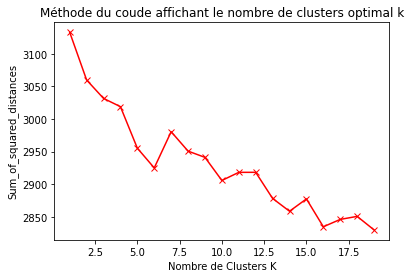

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from nltk.corpus import stopwords
# data = la variable sur laquelle appliquer la clustérisation
data = df['clust']

tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',max_features = 20000, decode_error='ignore')
#tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english', max_features=None ,decode_error='ignore')
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)

tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names_out()).head()


tf_idf_dtm = pd.DataFrame(tf_idf_norm.toarray(), columns=tf_idf_vectorizor.get_feature_names_out()).head()
tf_idf_dtm.shape

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
   km = KMeans(n_clusters=k, max_iter=300, n_init=10, random_state=0)
   km = km.fit(tf_idf)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'rx-')
plt.xlabel('Nombre de Clusters K')
plt.ylabel('Sum_of_squared_distances')
plt.title('Méthode du coude affichant le nombre de clusters optimal k')
plt.show()

In [ ]:
# update k en fonction du matplotlib precedent
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(tf_idf)
labels=model.labels_
#
df["labels"]=pd.Series(labels)
df["labels"].value_counts()

1    3342
2     305
4     166
3     111
0      76
Name: labels, dtype: int64

In [ ]:
# affichage labels sur un échantillon aléatoire
# df[labels==3][["labels","NER_header","NER_body","header"]].sample(20)
df[labels==9][["labels","header","NER_body","clust","best_sum","body_principal"]].sample(15)

,labels,header,NER_body,clust,best_sum,body_principal
2024,9,RE: meter 7361 - MTBE Plant/EGP Fuels (was 8216),"(days, Gas Daily, Daren J. Subject, April, Apr...",Deal kept whole. This baseload purchase. Deal ...,Deal should be kept whole.Deal should still a...,Deal should be kept whole. This is a baseload...
1873,9,Re: Cox Exploration,"(Mandey Cox, don, months, Carlos, Cox, D Mandy...",Mandey The Cox contract expired effective gas ...,Can you contact the producer and ask them to r...,Mandey The Cox contract expired effective so ...
2278,9,Killed deal,(),I killed deal . The contract number incorrect.,I killed deal . The contract number was incor...,I killed deal . The contract number was incor...
2654,9,"Preston Exploration, LLC","(X Ed McMichael X, Eric Moon, John Grass, Meli...",Preston Exploration LLC St. Mary Production LL...,t tFrom George Weissman AM t To Joan Quick HOU...,Preston Exploration LLC St. Mary s Production...
1876,9,Re: deal 34342,"(ENA day, Feb., daily, ENA, HPL, Daren Thu, Fe...",Re deal Why need extended This deal may able g...,D Aimee Lannou AM To Daren J Farmer HOU mail c...,Re deal Why do you need it extended This deal...
1882,9,Deal Number 109660,"(Karen Lindley Corp Enron, tFrom, Karen Lindle...",Deal Number Hi Mark Another interconnect issue...,Mark has informed me that one of you would ha...,Deal Number Hi Mark Another interconnect issu...
1864,9,Southern Union @ Mtr 8663,"(Janet Wallis, Gas Daily, Colorado River Stati...",I recevied note Janet Wallis stating need Gas ...,Gas Daily deals for imbalances at Colorado Riv...,I recevied a note from Janet Wallis stating t...
1909,9,PANENERGY MARKETING COMPANY,"(Folders, X Origin, Client Services, Client Se...",X bcc X Folder Darren Farmer Dec Notes Folders...,Because of a timing issue with Client Services...,X bcc X Folder Darren Farmer Dec Notes Folder...
1924,9,NaN,"(KMID, Midcon Texas, L Operator, Sitara, Neal,...",X Origin Farmer D X FileName dfarmer.nsf Deals...,Koch Midstream were in CES s system and ours a...,X Origin Farmer D X FileName dfarmer.nsf Deal...
2193,9,Re: Southwestern Public Service Co,"(Jennifer, Southwestern, mmbtu s. Thanks)",Jennifer agree Southwestern volume amount mmbt...,Jennifer we can agree to Southwestern s volum...,Jennifer we can agree to Southwestern s volum...


In [ ]:
file_name_out = file_name_out+'_clust'

In [ ]:
svgd_csv_xls (file_path,file_name_out)

Svgde effectuée -  Sep 21 2022 11:16  -  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/enron_unique_4000_clean_TFIDF Sep 18 2022 01:07_TFIDF_Spacy_Gensim_ Sep 18 2022 23:39_4000 Sep 19 2022 11:36_TFIDF_Spacy_Gensim_BART__BART2820 Sep 20 2022 01:53_TFIDF_Spacy_Gensim_BART_ Sep 20 2022 16:28_4000_clust Sep 21 2022 11:16.csv


# 4.2 Vectorization with Count Vectorizer

In [ ]:
# préparation du corpus de mots avec fonction de nettoyage
# prend une string / retourne une string

import re
def data_cleanstr(string):
    r = re.compile(r'[a-zA-Z0-9.-]*@[a-zA-Z0-9.-]*')
    tok=r.sub('mail', string)
    
    r = re.compile(r"([^a-zA-Z]+)")
    tok1=r.sub(' ', tok)
    return tok1

In [ ]:
# préparation fonction stopwords
# prend une string / retourne une string


def remove_stop_words(text):
    import spacy
    from spacy.lang.en.stop_words import STOP_WORDS
    stopwords=list(STOP_WORDS)
    lst=[]

    for token in text.split(" "):
        if token.lower() not in stopwords:    #checking whether the word is not 
            lst.append(token)                    #present in the stopword list.      
            result = ' '.join(lst)
    return result


In [ ]:
# tokenisation du corpus de mots, utilisation de la fonction de nettoyage et mise en minuscules
# prend retourne un dataframe / retourne une liste
import nltk
nltk.download('punkt')

def tokenize_mots(df):    
    texte=[]
    phrases=""
    from nltk.tokenize import word_tokenize

    for i in df['body_principal']:
        phrases+=i  
    a=data_cleanstr(str(phrases))
    mots=word_tokenize(a)
    mots=[i.lower() for i in mots]
    return mots

# création liste mots pour corpus sur le champs body_principal
mots=tokenize_mots(df)

# création liste mots pour corpus sans Stopwords
from spacy.lang.en.stop_words import STOP_WORDS
stopwords=list(STOP_WORDS)
mots_sans=[]
for mot in mots:
    if mot not in stopwords:
        mots_sans.append(mot)

print("nbr corpus :",len(mots))
print("nbr corpus sans stop words :",len(mots_sans))

In [ ]:
#NEW

def tokenize_mots_str(phr):    
    from nltk.tokenize import word_tokenize
    mots=word_tokenize(data_cleanstr(phr))
    mots=[i.lower() for i in mots]
    return mots



In [ ]:
# MAJ ////////////////////// de cette section pour prise en compte du NER N ou V
# lematisation du corpus, 2 ere ligne à réactiver si besoin
# prend une liste / retourne une liste

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lematize_mots(corpus):
    from nltk.stem import WordNetLemmatizer

    # Initialiser un lemmatiseur
    wordnet_lemmatizer = WordNetLemmatizer()

    #Calculer le lemme du mot meeting
    corp=[]
    for mot in corpus:
        corp.append(wordnet_lemmatizer.lemmatize(mot, pos=get_wordnet_pos(mot)))
    #utilisation de list(set()) pour supprimer les doublons
    return corp


corpus_sans=lematize_mots(mots_sans)

In [ ]:
print("nbr de mots",len(mots_sans))
print("nbr de mots après lemmatisation",len(corpus_sans))

In [ ]:
#NEW Prend une str / retourne une str --> lemmatizer optimisé

import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lematize_mots_str(phr):
    from nltk.stem import WordNetLemmatizer
    phrase=phr.split(" ")
    # Initialiser un lemmatiseur
    wordnet_lemmatizer = WordNetLemmatizer()

    #Calculer le lemme du mot meeting
    corp=[]
    for mot in phrase:
        corp.append(wordnet_lemmatizer.lemmatize(mot, pos=get_wordnet_pos(mot)))
    #utilisation de list(set()) pour supprimer les doublons
    return " ".join(corp)

lematize_mots_str("the word is very exciting")

In [ ]:
# vectorisation du corpus de mots
# retourne un dictionnaire

def bagofwords(corpus):
    from sklearn.feature_extraction.text import CountVectorizer

    # Créer un vectorisateur
    vectorizer = CountVectorizer()

    # Appliquer Bag of words à la variable tokens
    vectorizer.fit_transform(corpus).todense()

    # Récupération des tokens
    #tokenized = vectorizer.vocabulary_
    #token=dict(sorted(tokenized.items(),key= lambda x:x[1],reverse=True))
    #print(token)

    return vectorizer

#vectorizer=bagofwords(corpus)
vectorizer_sans=bagofwords(corpus_sans)

In [ ]:
# vectorisation de chaque email 1 par 1 et enregistrement dans une colonne dédiée body_vect, au passage création de body_clean

texte=[]
# on duplique le contenu de df vers df pour conserver les résultats antérieurs
df=df
df['body_clean']=""
df["body_vect"]=""
df["body_vect_sans"]=""
for i,j in enumerate(df['body_principal']):
    text=data_cleanstr(str(j))
    df.loc[i,"body_clean"]=text
    #df.loc[i,"body_vect"]=[vectorizer.transform([text]).toarray()]
    df.loc[i,"body_vect_sans"]=[vectorizer_sans.transform([text]).toarray()]
        
        
# liste contenant le corpus de mots, le premier avec les stopwords, le second sans les stopswords --> épuré des chiffres,
# et des signes de ponctuations ou autres

In [ ]:
df.isna().sum()

In [ ]:
#df=df.dropna()     # modif nicolas
lfunc = lambda e: e[0]
#df['body_vect2']=df['body_vect'].map(lambda x:lfunc(x))
df['body_vect_sans2']=df['body_vect_sans'].map(lambda x:lfunc(x))
df.head(5)

In [ ]:
# Franck : à supprimer car body_vect2 n'existe pas (?)

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

# Initialisaion de la figrue
plt.figure(figsize=(20, 10))

body_linkage = np.concatenate([i.reshape((1,-1)) for i in df.body_vect2.values], axis=0)
Z = linkage(body_linkage, method = 'ward', metric = 'euclidean')


plt.title("Dendrogramme CAH")
dendrogram(Z, labels = df.index, leaf_rotation = 90., color_threshold = 0)
plt.show()

In [ ]:
body_linkage_sans = np.concatenate([i.reshape((1,-1)) for i in df.body_vect_sans2.values], axis=0)
Z = linkage(body_linkage_sans, method = 'ward', metric = 'euclidean')

plt.figure(figsize=(20, 10))
plt.title("Dendrogramme CAH")
dendrogram(Z, labels = df.index, leaf_rotation = 90., color_threshold = 0)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=0)
   km = km.fit(body_linkage)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(body_linkage)
labels=model.labels_

print(pd.Series(labels))
print(len(df))

In [ ]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(body_linkage_sans)
labels_sans=model.labels_

print(pd.Series(labels))
print(len(df))

In [ ]:
df[df['labels']==1][['body_clean','labels']]

In [ ]:
df[df['labels_sans']==1][['body_clean','labels_sans']]

In [ ]:
df[df['labels']==2][['body_clean','labels']]

In [ ]:
df[df['labels_sans']==2][['body_clean','labels_sans']]

# 4.3 Clusterisation avec W2V

In [ ]:
#NEW Prend une str / retourne une str --> lemmatizer optimisé

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lematize_mots_str(phr):
    from nltk.stem import WordNetLemmatizer
    phrase=phr.split(" ")
    # Initialiser un lemmatiseur
    wordnet_lemmatizer = WordNetLemmatizer()

    #Calculer le lemme du mot meeting
    corp=[]
    for mot in phrase:
        corp.append(wordnet_lemmatizer.lemmatize(mot, pos=get_wordnet_pos(mot)))
    #utilisation de list(set()) pour supprimer les doublons
    return " ".join(corp)

lematize_mots_str("the word is very exciting")

In [ ]:
df.info()

In [ ]:
# nettoyage du texte

texte=[]
df['body_clean']=""

for i,j in enumerate(df['body_principal']):
    df.loc[i,"body_clean"]=lematize_mots_str((data_cleanstr(str(j))))

In [ ]:
df.head(10)

In [ ]:
# nettoyage stopwords

df['body_clean_SW']=df['body_clean'].apply(lambda l:remove_stop_words(l))

In [ ]:
# NEW 

import gensim.downloader as api
model = api.load("glove-wiki-gigaword-200")

In [ ]:
model[df['body_clean_SW'][0]]

In [ ]:
df['body_clean_SW'].isna().sum()

In [ ]:
# NEW création de la fonction vect_W2V pour créer la sommation de vecteurs de chaque tokens pour une phrase donnée
import numpy as np

def vect_W2V(a):
    liste=tokenize_mots_str(a)
    vecteur=np.zeros((200,), dtype = 'float32')
    mot_lost=[]
    for mot in liste:
        try:
            vect=model[mot]
            vecteur+=vect
        except:
            mot_lost.append(mot)
    return vecteur

In [ ]:
import nltk
nltk.download('punkt')
# NEW pplication de la fonction dans une colonne dédié du Dataframe
df['body_vect_W2V']=""        
df['body_vect_W2V']=df['body_clean_SW'].apply(lambda l:vect_W2V(l))    

In [ ]:
df.head(5)

In [ ]:
df['body_vect_W2V'][10]

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

body_linkage_W2V = np.concatenate([i.reshape((1,-1)) for i in df.body_vect_W2V.values], axis=0)

Sum_of_squared_distances = []
K = range(1,20)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=0)
   km = km.fit(body_linkage_W2V)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# NEW
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(body_linkage_W2V)
labels_W2V=model.labels_

print(pd.Series(labels_W2V))
print(len(df))

In [ ]:
# NEW

df['labels_W2V']=pd.Series(labels_W2V)
print(df['labels_W2V'].unique())
# print(len(df[df['labels_W2V']==0]))
# print(len(df[df['labels_W2V']==1]))
# print(len(df[df['labels_W2V']==2]))
# print(len(df[df['labels_W2V']==3]))

df['labels_W2V'].value_counts()

In [ ]:
# New --> test avec label 0
df[df['labels_W2V']==0][['body_clean']]

In [ ]:
# New --> test avec label 1
df[df['labels_W2V']==1][['body_clean']]

In [ ]:
# New --> test avec label 2
df[df['labels_W2V']==2][['body_clean']]

In [ ]:
# New --> test avec label 3
df[df['labels_W2V']==3][['body_clean']]

# 4.4 Test Word2Vec

In [ ]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

#import logging  # Setting up the loggings to monitor gensim
#logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [ ]:
# 
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes / removes stopwords
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
clean = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['body_principal'])

In [ ]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(clean, batch_size=5000)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))



> Put the results in a DataFrame to remove missing values and duplicates:



In [ ]:
df_clean = pd.DataFrame({'body_initial':df['body_principal'],'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

In [ ]:
df_clean.head()

> Bigrams



In [ ]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]



> Most Frequent Words:



In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

print(len(word_freq))
print(sorted(word_freq, key=word_freq.get, reverse=True)[:100])

In [ ]:
import multiprocessing
from gensim.models import Word2Vec
from time import time
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_model1 = Word2Vec(min_count=5,window=5,size=300,sample=6e-5,alpha=0.03,min_alpha=0.0007, negative=20,workers=cores-1)
w2v_model2 = Word2Vec(sentences=sentences, size=200, window=5, workers=-1, min_count=5)

t = time()
# Building the Vocabulary Table
w2v_model1.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
#w2v_model2.build_vocab(sentences, progress_per=10000)

# Training of the model
t = time()

w2v_model1.train(sentences, total_examples=w2v_model1.corpus_count, epochs=30, report_delay=1)
#w2v_model2.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
# Exploring the model
word = ["customer"]
w2v_model1.wv.most_similar(positive=word),'---',w2v_model2.wv.most_similar(positive=word)